In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import warnings
from geopy.distance import geodesic

warnings.filterwarnings("ignore")

In [ ]:
lag = 0

In [7]:
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')

In [ ]:
# Import the depth_to_basement data
import xarray as xr
from scipy import interpolate
from netCDF4 import Dataset as netcdf_dataset
import matplotlib.pyplot as plt

fn = "../datasets/GeologicalData/Basement_depth/DepthtoBasement_Anadarko_0.01deg.grd"
nc = xr.open_dataset(fn)
nc.z.to_dataframe().to_csv('../datasets/GeologicalData/Basement_depth/DepthtoBasement.csv')
df = pd.read_csv("../datasets/GeologicalData/Basement_depth/DepthtoBasement.csv")
df['z'].fillna(0, inplace=True)

In [ ]:
# Visualize the depth_to_basement data
df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lat', 'lon'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf['x_m'], gdf['y_m'] = gdf.geometry.x, gdf.geometry.y

# Interpolate onto discrete grid (for plotting smooth contours)
x_all = np.arange(-103.2, -95.8, 0.01)
y_all = np.arange(32.5, 38.3, 0.01)


xx, yy = np.meshgrid(x_all, y_all)
z_interp = interpolate.griddata((gdf['x_m'].values, gdf['y_m'].values), gdf['z'].values, (xx, yy),
                                method='linear')

ax = plt.subplot()
c = ax.contourf(xx, yy, z_interp, label="Smoothed depth to basement", levels=20)
cbar = plt.colorbar(c)
cbar.set_label("Depth to basement [m]")
ax.set_xlim(-99.5, -96)
ax.set_ylim(35, 37)
ax.set_title('Depth to Basement', fontsize=10,fontweight='bold')

basement_df = df

# Earthquake dataSet

In [2]:
# Import the earthquake data
inputdir = "../datasets/EarthquakeData"
all_earthquake_df = pd.DataFrame()

for root, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        tmp_df = pd.read_csv(os.path.join(root, filename))
        all_earthquake_df = all_earthquake_df.append(tmp_df, ignore_index=True)

In [3]:
# Preprocess the earthquake data
all_earthquake_df['origintime'] = all_earthquake_df['origintime'].astype('datetime64')
all_earthquake_df['Origin Date'] = all_earthquake_df['origintime']
all_earthquake_df = all_earthquake_df.set_index('origintime')
all_earthquake_df = all_earthquake_df[['magnitude', 'latitude', 'longitude', 'Origin Date']]
all_earthquake_df = all_earthquake_df["2010":"2021"]

## Select earthquake data by time

In [4]:
earthquake_start = 2011
earthquake_end = 2018
# earthquake_df = all_earthquake_df[str(earthquake_start):str(earthquake_end)]
earthquake_df = all_earthquake_df

In [5]:
earthquake_df.sort_values(by='origintime')

,magnitude,latitude,longitude,Origin Date
origintime,,,,
2010-01-01 18:45:53,2.6,35.564000,-97.175000,2010-01-01 18:45:53
2010-01-11 05:16:00,2.8,35.528000,-97.297000,2010-01-11 05:16:00
2010-01-14 10:05:35,3.2,35.495490,-97.200150,2010-01-14 10:05:35
2010-01-15 15:18:27,3.8,35.527000,-97.299000,2010-01-15 15:18:27
2010-01-15 15:27:02,3.7,35.528000,-97.304000,2010-01-15 15:27:02
...,...,...,...,...
2021-05-30 04:02:02,2.3,36.532452,-98.980141,2021-05-30 04:02:02
2021-05-30 15:26:45,2.4,35.102898,-95.335548,2021-05-30 15:26:45
2021-05-30 22:07:46,2.3,34.627842,-96.307716,2021-05-30 22:07:46


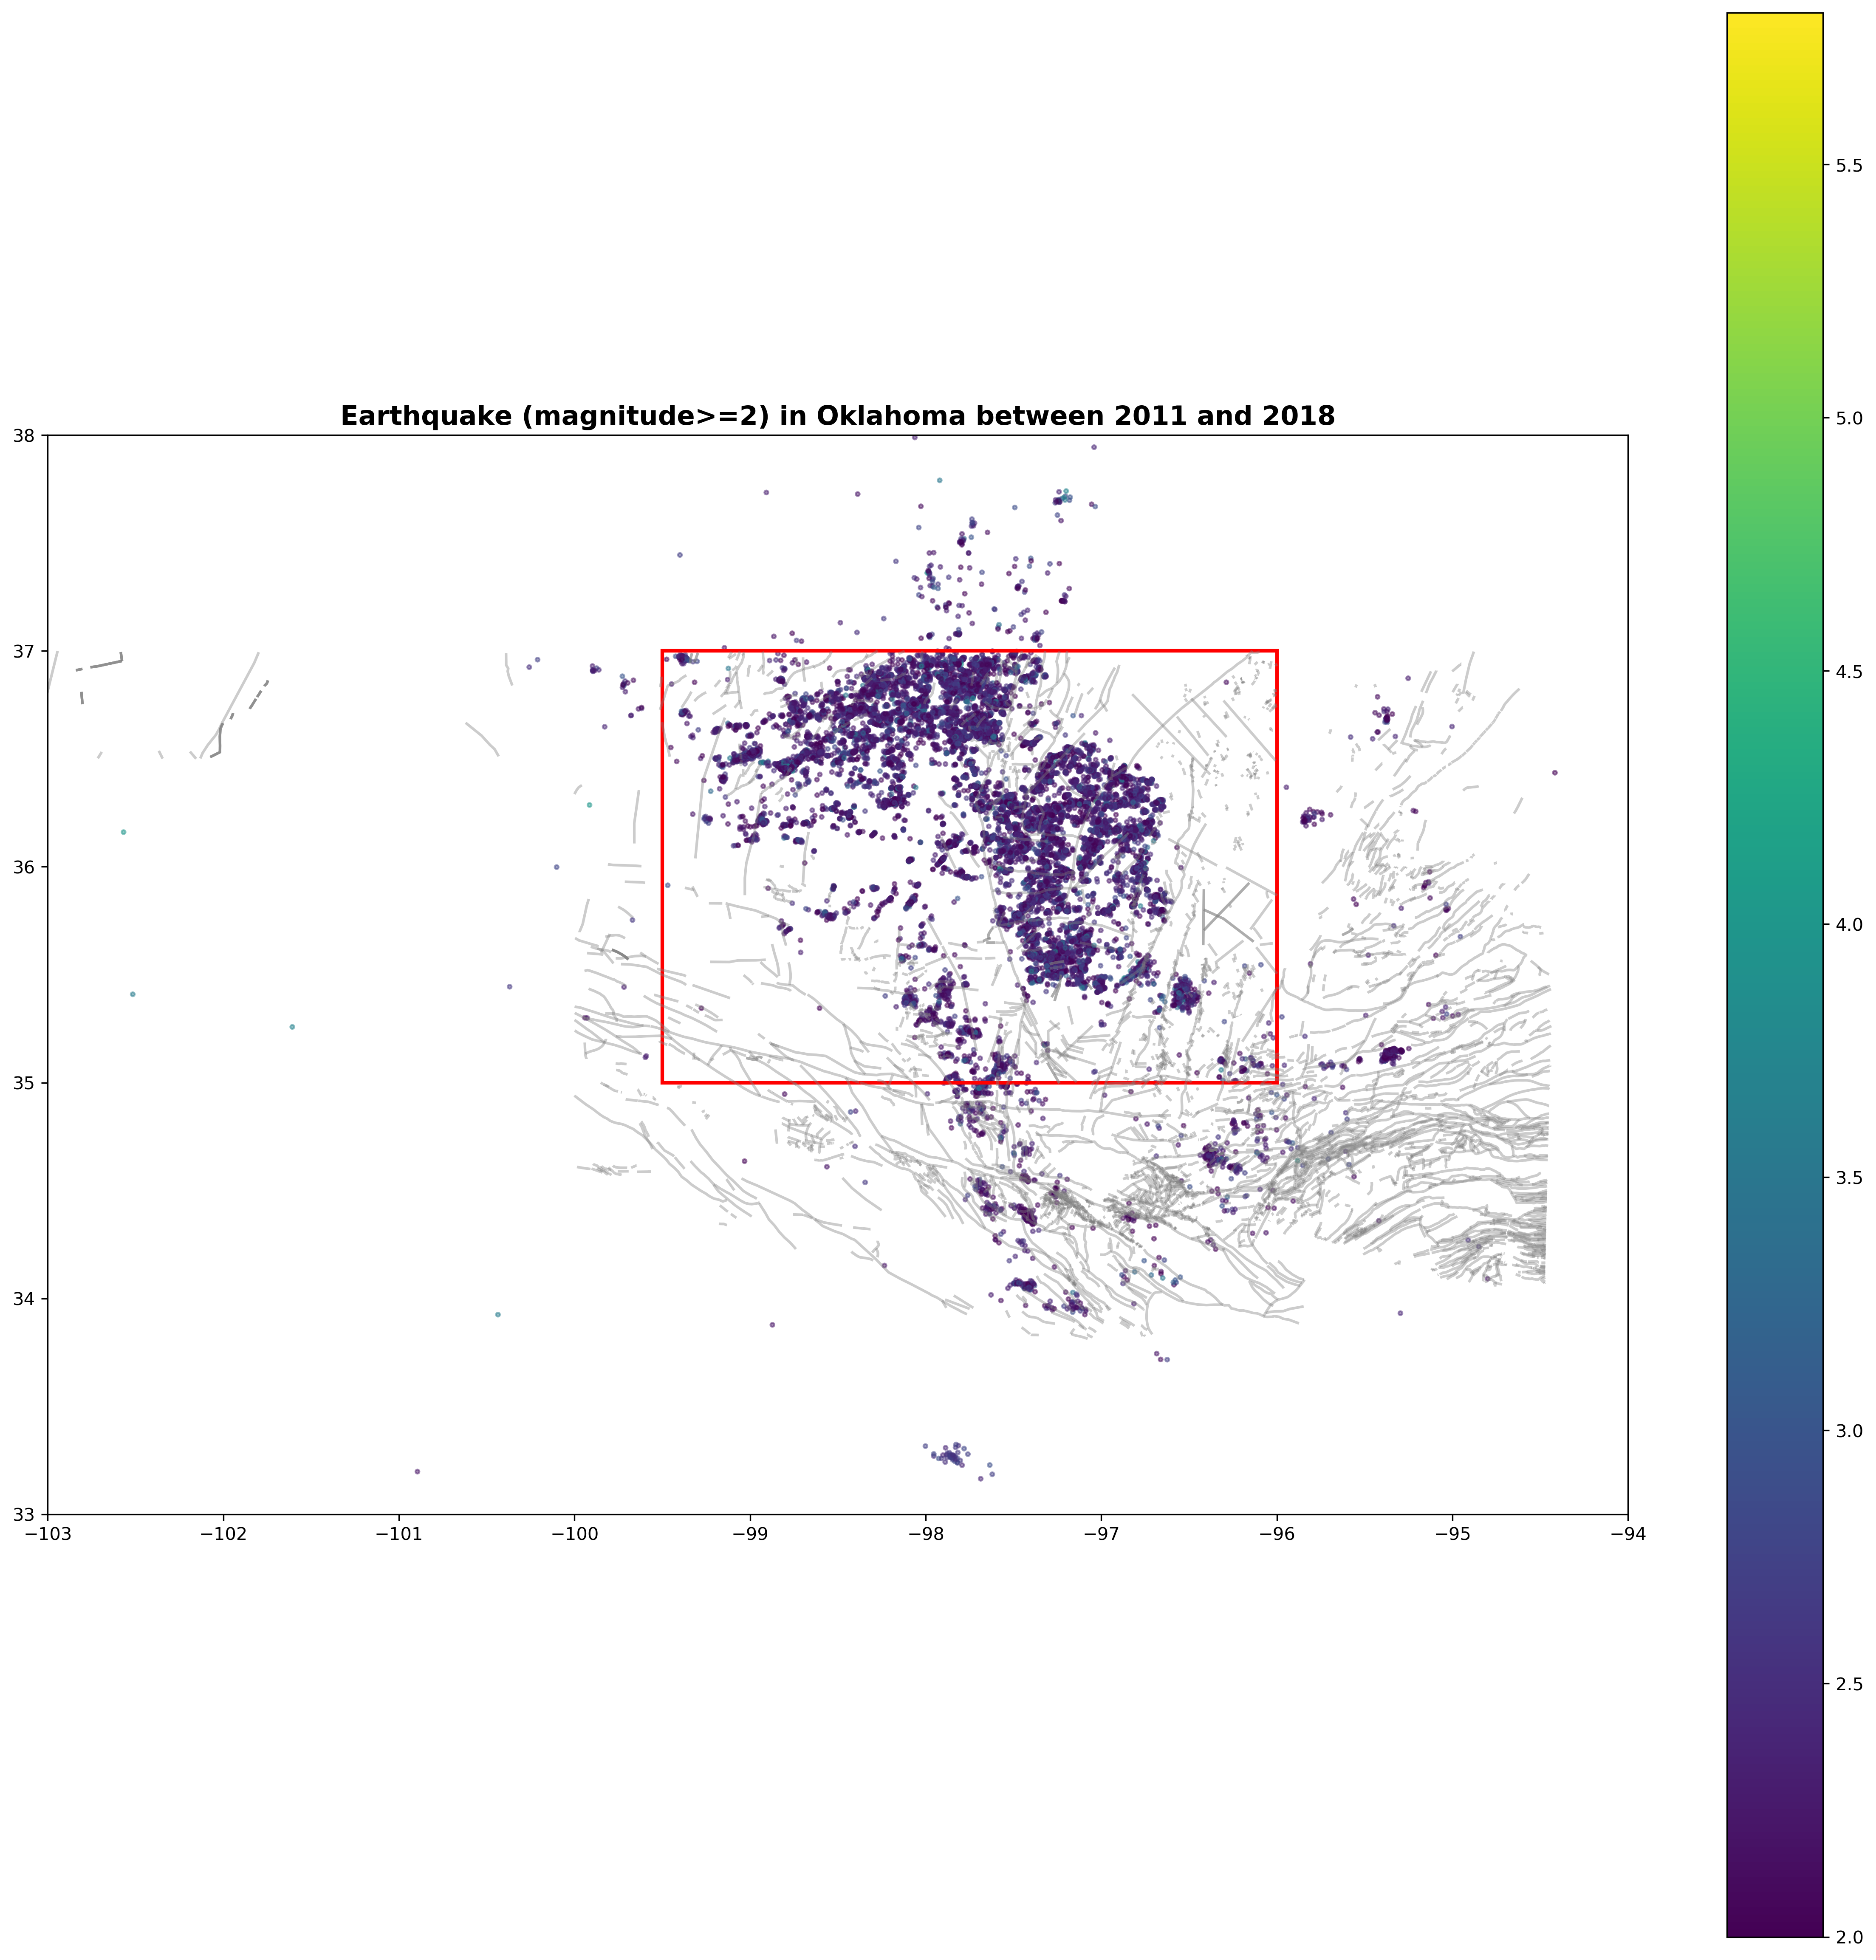

In [8]:
# zip x and y coordinates into single feature
earthquake_geometry = [Point(xy) for xy in zip(earthquake_df['longitude'], earthquake_df['latitude'])]

# create GeoPandas dataframe
earthquake_geo_df = gpd.GeoDataFrame(earthquake_df, crs = "EPSG:4326", geometry = earthquake_geometry) #4326 is the code for a lat,long coordinate system

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
# add .shp mapfile to axes
oklahoma_map.plot(ax=ax, alpha=0.4,color='grey')

# add geodataframe to axes
# assign ‘magnitude’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
earthquake_geo_df.plot(column='magnitude',ax=ax, alpha=0.5, legend=True, markersize=5)

rec = plt.gca()
rec.add_patch(plt.Rectangle((-99.5, 35), 3.5, 2, color="red", fill=False, linewidth=2))

# add title to graph
plt.title('Earthquake (magnitude>=2) in Oklahoma between '+str(earthquake_start)+' and '+str(earthquake_end), fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-103, -94)
plt.ylim(33, 38)

# show map
plt.show()

# Injection dataset

In [ ]:
# injection data
inputdir = "../datasets/OCC_injection_data/YearlyInjectionRecords"
# inputdir = "datasets/OCC_injection_data/MonthlyInjectionRecords"
yearly_injection_df = pd.DataFrame()

for root, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        tmp_df = pd.read_excel(os.path.join(root, filename))
        yearly_injection_df = yearly_injection_df.append(tmp_df, ignore_index=True)

In [ ]:
# Preprocess the injection dataset
yearly_injection_df['Year Vol'] = yearly_injection_df['Jan Vol'] + \
                                yearly_injection_df['Feb Vol'] + \
                                yearly_injection_df['Mar Vol'] + \
                                yearly_injection_df['Apr Vol'] + \
                                yearly_injection_df['May Vol'] + \
                                yearly_injection_df['Jun Vol'] + \
                                yearly_injection_df['Jul Vol'] + \
                                yearly_injection_df['Aug Vol'] + \
                                yearly_injection_df['Sep Vol'] + \
                                yearly_injection_df['Oct Vol'] + \
                                yearly_injection_df['Nov Vol'] + \
                                yearly_injection_df['Dec Vol']
yearly_injection_df['Year PSI'] = yearly_injection_df['Jan PSI'] + \
                                yearly_injection_df['Feb PSI'] + \
                                yearly_injection_df['Mar PSI'] + \
                                yearly_injection_df['Apr PSI'] + \
                                yearly_injection_df['May PSI'] + \
                                yearly_injection_df['Jun PSI'] + \
                                yearly_injection_df['Jul PSI'] + \
                                yearly_injection_df['Aug PSI'] + \
                                yearly_injection_df['Sep PSI'] + \
                                yearly_injection_df['Oct PSI'] + \
                                yearly_injection_df['Nov PSI'] + \
                                yearly_injection_df['Dec PSI']

yearly_injection_df = yearly_injection_df.dropna(subset=["LAT", "LON"])
# Set Report_Year as index
yearly_injection_df['ReportYear'] = yearly_injection_df['ReportYear'].astype('datetime64')
yearly_injection_df = yearly_injection_df.set_index('ReportYear')
yearly_injection_df = yearly_injection_df[['TotalDepth', 'LAT', 'LON', 'FluidType', 'Year Vol', 'Year PSI', \
                                           'Jan Vol', 'Feb Vol', 'Mar Vol', 'Apr Vol', 'May Vol', 'Jun Vol', 'Jul Vol', 'Aug Vol', 'Sep Vol', 'Oct Vol', 'Nov Vol', 'Dec Vol', \
                                           'Jan PSI', 'Feb PSI', 'Mar PSI', 'Apr PSI', 'May PSI', 'Jun PSI', 'Jul PSI', 'Aug PSI', 'Sep PSI', 'Oct PSI', 'Nov PSI', 'Dec PSI']]

In [ ]:
# Process the injection data with depth_to_basement data
depth_to_basement_list = []
for index_injection, row_injection in yearly_injection_df.iterrows():
    depth_to_basement = df[(df['y_m']==round(row_injection['LAT'],2)) & (df['x_m']==round(row_injection['LON'],2))]['z'].values
    if len(depth_to_basement)==0:
        depth_to_basement_list.append(np.NaN)
    else:
        depth_to_basement_list.append(depth_to_basement[0])
        
yearly_injection_df['depth to basement'] = depth_to_basement_list
yearly_injection_df = yearly_injection_df.dropna()
yearly_injection_df['depth to basement'] = yearly_injection_df['depth to basement'] * 3.28
yearly_injection_df['injection depth relative to basement'] = yearly_injection_df['TotalDepth'] - yearly_injection_df['depth to basement']

## Injection data selection by time

In [ ]:
# injection_df = monthly_injection_df
injection_start = earthquake_start - lag
injection_end = earthquake_end - lag
injection_df = yearly_injection_df.loc[str(injection_start):str(injection_end)]

In [ ]:
injection_df.sort_values(by='ReportYear')

In [ ]:
# zip x and y coordinates into single feature
injection_geometry = [Point(xy) for xy in zip(injection_df['LON'], injection_df['LAT'])]
# create GeoPandas dataframe
injection_geo_df = gpd.GeoDataFrame(injection_df, crs = "EPSG:4326", geometry = injection_geometry)

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
# add .shp mapfile to axes
oklahoma_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘FluidType’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
injection_geo_df.plot(column='FluidType',ax=ax, alpha=0.5, legend=True, markersize=10)
# add title to graph
plt.title('Injection-Year Vol in Oklahoma between '+str(injection_start)+' and '+str(injection_end), fontsize=15,fontweight='bold')

rec = plt.gca()
rec.add_patch(plt.Rectangle((-99.5, 35), 3.5, 2, color="red", fill=False, linewidth=2))
# set latitiude and longitude boundaries for map display
plt.xlim(-103, -94)
plt.ylim(33, 38)
plt.show()

# Well dataset

In [ ]:
inputdir = "../datasets/WellData/"
all_well_df = pd.read_csv(inputdir + "Export - Excel Well Workbook_Header.csv")

In [ ]:
all_well_df = all_well_df.dropna(subset=["Permit Date", 'Date First Report', 'Date Last Activity', "Depth Total Projected", "Surface Latitude", "Surface Longitude"])
all_well_df = all_well_df.set_index('Permit Date')
all_well_df['Date First Report'] = all_well_df['Date First Report'].astype('datetime64')
all_well_df['Date Last Activity'] = all_well_df['Date Last Activity'].astype('datetime64')
all_well_df = all_well_df[['Date First Report', 'Date Last Activity', "Depth Total Projected", "Hole Direction", "Surface Latitude", "Surface Longitude"]]
all_well_df = all_well_df[all_well_df['Hole Direction']=='VERTICAL']


depth_to_basement_list = []
for index_well, row_well in all_well_df.iterrows():
    depth_to_basement = df[(df['y_m']==round(row_well['Surface Latitude'],2)) & (df['x_m']==round(row_well['Surface Longitude'],2))]['z'].values
    if len(depth_to_basement)==0:
        depth_to_basement_list.append(np.NaN)
    else:
        depth_to_basement_list.append(depth_to_basement[0])
        
all_well_df['depth to basement'] = depth_to_basement_list

all_well_df = all_well_df.dropna()
all_well_df['depth to basement'] = all_well_df['depth to basement'] * 3.28
all_well_df['well depth relative to basement'] = all_well_df['Depth Total Projected'] - all_well_df['depth to basement']

In [ ]:
all_well_df.sort_values(by='Permit Date')

## Well data by time

In [ ]:
well_start = earthquake_start - lag
well_df = all_well_df[all_well_df['Date Last Activity']>str(well_start)]

In [ ]:
well_df.isnull().any()

In [ ]:
# zip x and y coordinates into single feature
well_geometry = [Point(xy) for xy in zip(well_df['Surface Longitude'], well_df['Surface Latitude'])]

# create GeoPandas dataframe
well_geo_df = gpd.GeoDataFrame(well_df, crs = "EPSG:4326", geometry = well_geometry)

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
# add .shp mapfile to axes
oklahoma_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘Depth Total Projected’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
well_geo_df.plot(column='Depth Total Projected',ax=ax, alpha=0.5, legend=True, markersize=5)
# add title to graph
plt.title('Well in Oklahoma Last Activity after' + str(well_start), fontsize=15,fontweight='bold')

rec = plt.gca()
rec.add_patch(plt.Rectangle((-99.5, 35), 3.5, 2, color="red", fill=False, linewidth=2))
# set latitiude and longitude boundaries for map display
plt.xlim(-103, -94)
plt.ylim(33, 38)

# show map
plt.show()

# Hydralic Fracturing Data

In [ ]:
# injection data
inputdir = "../datasets/HydraulicFracturingData/FracFocusCSV"
# inputdir = "datasets/OCC_injection_data/MonthlyInjectionRecords"
all_HF = pd.DataFrame()

for root, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        tmp_df = pd.read_csv(os.path.join(root, filename))
        all_HF = all_HF.append(tmp_df, ignore_index=True)

In [ ]:
# all_HF['JobStartDate'] = all_HF['JobStartDate'].astype('datetime64')
all_HF = all_HF.dropna(subset=["JobStartDate", "JobEndDate", "Latitude", "Longitude"])
all_HF['TotalBaseWaterVolume'].fillna(0, inplace=True)
all_HF['TotalBaseNonWaterVolume'].fillna(0, inplace=True)
all_HF['JobStartDate'] = pd.to_datetime(all_HF['JobStartDate'], errors='coerce')
all_HF['JobEndDate'] = pd.to_datetime(all_HF['JobEndDate'], errors='coerce')
all_HF = all_HF[(all_HF['Latitude']>33.4)&(all_HF['Latitude']<37)&(all_HF['Longitude']>-103)&(all_HF['Longitude']<94.3)]

In [ ]:
all_HF.sort_values(by='JobEndDate')['JobEndDate']

# Select hydralic fracturing data by time

In [ ]:
HF_start = earthquake_start - lag
HF_end = earthquake_end - lag

In [ ]:
HF_df = all_HF[(all_HF['JobStartDate']>=str(HF_start)) & (all_HF['JobStartDate']<=str(HF_end))]

In [ ]:
# zip x and y coordinates into single feature
HF_geometry = [Point(xy) for xy in zip(HF_df['Longitude'], HF_df['Latitude'])]

# create GeoPandas dataframe
HF_geo_df = gpd.GeoDataFrame(HF_df, crs = "EPSG:4326", geometry = HF_geometry)

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
# add .shp mapfile to axes
oklahoma_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
well_geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=5)
# add title to graph
plt.title('HF in Oklahoma Last Activity after between '+str(HF_start)+' and '+str(HF_end), fontsize=15,fontweight='bold')

rec = plt.gca()
rec.add_patch(plt.Rectangle((-99.5, 35), 3.5, 2, color="red", fill=False, linewidth=2))
# set latitiude and longitude boundaries for map display
plt.xlim(-103, -94)
plt.ylim(33, 38)

# show map
plt.show()

# Gridding

In [ ]:
m, n = (41, 41)
x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
# add .shp mapfile to axes
oklahoma_map.plot(ax=ax, alpha=0.4,color='grey')
# add geodataframe to axes
# assign ‘Depth Total Projected’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
ax.plot(X, Y, marker = '.', color='blue', linestyle='none')

minor_x_ticks=np.linspace(-99.5,-96,m)
major_x_ticks=np.linspace(-99.5,-96,int((m-1)/5+1))
minor_y_ticks=np.linspace(35,37,n)
major_y_ticks=np.linspace(35,37,int((n-1)/5+1))
ax.set_xticks(major_x_ticks)
ax.set_yticks(major_y_ticks)
ax.set_xticks(minor_x_ticks, minor=True)
ax.set_yticks(minor_y_ticks, minor=True)
ax.grid(color='blue', linestyle='-', linewidth=2, which='major')
ax.grid(color='blue', linestyle='-', linewidth=2, which='minor')

# add title to graph
# set latitiude and longitude boundaries for map display
plt.xlim(-99.5, -96)
plt.ylim(35, 37)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

In [ ]:
from geopy.distance import geodesic
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x

x_length = geodesic((35,-99.5),(35,-96)).km / (m-1)
y_length = geodesic((35,-96),(37,-96)).km / (n-1)

print("gridding x-direction length: ", x_length, "km")
print("gridding y-direction length: ", y_length, "km")

# Count earthquake data for each gridding region

In [ ]:
iter_num = 0
earthquake_list = []
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if_earthquake = 1 if grid.shape[0]>0 else 0
        earthquake_list.append(if_earthquake)
        iter_num = iter_num + 1
        if iter_num % 100 == 0:
            print(round(iter_num / ((len(lat)-1)*(len(lon)-1)) *100, 2), "%")

# Calculate injection volume，pressure data for each gridding region

In [ ]:
injection_number_list = []
injection_depth_avg_list = []
injection_vol_list = []
injection_PSI_list = []
injection_above_basement_list = []
injection_under_basement_list = []
injection_close_to_basement_500_list = []
injection_close_to_basement_1000_list = []

iter_num = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        injection_adjacent = injection_df[(injection_df['LAT']>lat[la_index])&(injection_df['LAT']<lat[la_index+1])&(injection_df['LON']>lon[lo_index])&(injection_df['LON']<lon[lo_index+1])]
        injection_number_list.append(injection_adjacent.shape[0])
        injection_depth_avg_list.append(injection_adjacent['TotalDepth'].sum() / injection_adjacent.shape[0])
        injection_vol_list.append(injection_adjacent['Year Vol'].sum())
        injection_PSI_list.append(injection_adjacent['Year PSI'].sum())
        injection_above_basement_list.append(injection_adjacent[injection_adjacent['injection depth relative to basement']<0].shape[0])
        injection_under_basement_list.append(injection_adjacent[injection_adjacent['injection depth relative to basement']>0].shape[0])
        injection_close_to_basement_500_list.append(injection_adjacent[injection_adjacent['injection depth relative to basement'].abs()<500].shape[0])
        injection_close_to_basement_1000_list.append(injection_adjacent[injection_adjacent['injection depth relative to basement'].abs()<1000].shape[0])
        iter_num = iter_num + 1
        if iter_num % 100 == 0:
            print(round(iter_num / ((len(lat)-1)*(len(lon)-1)) *100, 2), "%")

# Calculate well data for each gridding region

In [ ]:
active_well_number = []
well_depth_avg = []
well_above_basement = []
well_under_basement = []
well_close_to_basement_500_list = []
well_close_to_basement_1000_list = []

iter_num = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        grid = well_df[(well_df['Surface Latitude']>lat[la_index])&(well_df['Surface Latitude']<lat[la_index+1])&(well_df['Surface Longitude']>lon[lo_index])&(well_df['Surface Longitude']<lon[lo_index+1])]
        active_well_number.append(grid.shape[0])
        well_depth_avg.append(grid['Depth Total Projected'].sum()/grid.shape[0])
        well_above_basement.append(grid[grid['well depth relative to basement']<0].shape[0])
        well_under_basement.append(grid[grid['well depth relative to basement']>0].shape[0])
        well_close_to_basement_500_list.append(grid[grid['well depth relative to basement'].abs()<500].shape[0])
        well_close_to_basement_1000_list.append(grid[grid['well depth relative to basement'].abs()<1000].shape[0])
        
        iter_num = iter_num + 1
        if iter_num % 100 == 0:
            print(round(iter_num / ((len(lat)-1)*(len(lon)-1)) *100, 2), "%")

# Calcute depth to basement data for each gridding region

In [ ]:
depth_to_basement_list = []

iter_num = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        grid = basement_df[(basement_df['y_m']>lat[la_index])&(basement_df['y_m']<lat[la_index+1])&(basement_df['x_m']>lon[lo_index])&(basement_df['x_m']<lon[lo_index+1])]
        depth_to_basement_list.append(grid['z'].mean())
        
        iter_num = iter_num + 1
        if iter_num % 100 == 0:
            print(round(iter_num / ((len(lat)-1)*(len(lon)-1)) *100, 2), "%")

# Calculate hydralic fracturing data for each gridding region

In [ ]:
HF_list = []
HF_Base_Water_Volume_list = []
HF_Base_NoWater_Volume_list = []

iter_num = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
        grid = HF_df[(HF_df['Latitude']>lat[la_index])&(HF_df['Latitude']<lat[la_index+1])&(HF_df['Longitude']>lon[lo_index])&(HF_df['Longitude']<lon[lo_index+1])]
        HF_list.append(grid.shape[0])
        HF_Base_Water_Volume_list.append(grid['TotalBaseWaterVolume'].sum())
        HF_Base_NoWater_Volume_list.append(grid['TotalBaseNonWaterVolume'].sum())
        
        iter_num = iter_num + 1
        if iter_num % 100 == 0:
            print(round(iter_num / ((len(lat)-1)*(len(lon)-1)) *100, 2), "%")

# Organize all calculated data

In [ ]:
data_df = pd.DataFrame({'injection_number':injection_number_list,
                        'injection_vol_sum':injection_vol_list,
                        'injection_psi_sum':injection_PSI_list,
                        'injection_depth_avg':injection_depth_avg_list,
                        'injection_above_basement_number': injection_above_basement_list,
                        'injection_under_basement_number': injection_under_basement_list,
                        'injection_close_to_basement_500_number': injection_close_to_basement_500_list,
                        'injection_close_to_basement_1000_number': injection_close_to_basement_1000_list,
                        'active_well_number':active_well_number,
                        'well_depth_avg': well_depth_avg,
                        'well_above_basement_number': well_above_basement,
                        'well_under_basement_number': well_under_basement,
                        'well_close_to_basement_500_number': well_close_to_basement_500_list,
                        'well_close_to_basement_1000_number': well_close_to_basement_1000_list,
                        "depth_to_basement_avg": depth_to_basement_list,
                        "hf_number": HF_list,
                        "hf_base_water_volume_sum": HF_Base_Water_Volume_list,
                        "hf_base_nowater_volume_sum": HF_Base_NoWater_Volume_list,
                        'earthquake_occurence': earthquake_list})

In [ ]:
data_df.isnull().any()

In [ ]:
# fill avg_depth=NAN of gird to 0, for some grid region does not have injection or wells 
data_df = data_df.fillna(0)

In [ ]:
data_df

# Save the data file to data directory

In [ ]:

data_df.to_csv('../data/'+str(earthquake_start)+'-'+str(earthquake_end)+'_'+str(m-1)+'*'+str(n-1)+'_rectangular_mode_features.csv', index = False)

# Visualize the seismicity

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

labels = data_df['earthquake_occurence']

m = int(pow(len(data_df), 0.5))+1
n = int(pow(len(data_df), 0.5))+1

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('../datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')


lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = labels

i = 0
target_number = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(i)
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            target_number = target_number + 1
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

        
minor_x_ticks=np.linspace(-99.5,-96,m)
major_x_ticks=np.linspace(-99.5,-96,int((m-1)/5+1))
minor_y_ticks=np.linspace(35,37,n)
major_y_ticks=np.linspace(35,37,int((n-1)/5+1))
ax1.set_xticks(major_x_ticks)
ax1.set_yticks(major_y_ticks)
ax1.set_xticks(minor_x_ticks, minor=True)
ax1.set_yticks(minor_y_ticks, minor=True)
ax1.grid(color='w', linestyle='-', linewidth=2, which='major')
ax1.grid(color='w', linestyle='-', linewidth=2, which='minor')

selected_earthquake_df = earthquake_df[(earthquake_df['latitude']>35)&(earthquake_df['latitude']<37)&(earthquake_df['longitude']>-99.5)&(earthquake_df['longitude']<-96)]
selected_earthquake_geometry = [Point(xy) for xy in zip(selected_earthquake_df['longitude'], selected_earthquake_df['latitude'])]
selected_earthquake_geo_df = gpd.GeoDataFrame(selected_earthquake_df, crs = "EPSG:4326", geometry = selected_earthquake_geometry) #4326 is the code for a lat,long coordinate system
selected_earthquake_geo_df.plot(color='w', marker='o', ax=ax1, alpha=0.5, legend=True, markersize=20)

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
# ax1.set_title('Seismicity Distribution', fontsize=15,fontweight='bold')

red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
point = Line2D([0], [0], marker='o', color='black', label='Earthquake Occurence',
                          markerfacecolor='w', markersize=20)
ax1.legend(handles=[red_patch, blue_patch, point], fontsize=20)
plt.show()

# Correlation heatmap for all constructed features

In [ ]:
import seaborn as sns
data=data_df
# correlation calculation
dcorr = data.corr()
plt.figure(figsize=(10, 10),dpi=100)
fig = sns.heatmap(data=dcorr, annot=True, fmt=".2f")

heat_fig = fig.get_figure()